### Dados

**Entendimento dos dados:** Notebook *nyc_turnstile_estudos.ipynb*

**Metadados da base de entrada**

  
  
C/A      = Control Area (A002)  
UNIT     = Remote Unit for a station (R051)  
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)  
STATION  = Represents the station name the device is located at  
LINENAME = Represents all train lines that can be boarded at this station  
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.  
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND     
DATE     = Represents the date (MM-DD-YY)  
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event  
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)  
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.   
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.   
ENTRIES  = The comulative entry register value for a device  
EXIST    = The cumulative exit register value for a device


### Importing Data

In [3]:
from datetime import datetime 
from tqdm import tqdm
import pandas as pd
import numpy as np
import os, sys
import gc

from pandas.tseries.holiday import Holiday, USMemorialDay, AbstractHolidayCalendar, nearest_workday, MO

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

#model
from sklearn.ensemble import RandomForestRegressor

# validação
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle


*Foi criada a ***"utils_nyc_turnstile.py"*** para facilitar os tratamentos da base conforme os estudos em ***nyc_turnstile_estudos.ipynb***.*

In [30]:
%load_ext autoreload
%autoreload 2

from utils_nyc_turnstile import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%%time

# Open a file
path = "data/dados_desafio"
dirs = os.listdir(path)

df_years=[]

for file in tqdm(dirs):
    df = pd.read_csv("data/dados_desafio/{}".format(file),compression='gzip')    
    df_years.append(dataset_transform(df))
#import gc
#gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:53<00:00, 36.69s/it]


Wall time: 4min 53s


In [13]:
# 0 to 8: 2010 to 2017
yeas_list = np.arange(2010,2017)

for df, y in zip(df_years, yeas_list):
    print(y, df.shape)

2010 (93511, 3)
2011 (138369, 3)
2012 (137787, 3)
2013 (137943, 3)
2014 (135980, 3)
2015 (139861, 3)
2016 (135885, 3)


### Data Cleaning

In [14]:
df_full = pd.concat(df_years, axis = 0, sort = False).reset_index(drop = True)
#df_full.to_csv("data/output/df_full.csv", index = False)

#del df_years
gc.collect()

59

In [15]:
df_full.head()

,station,date,daily_entries
0,1 AVE,2010-04-17,0.0
1,1 AVE,2010-04-18,16000.0
2,1 AVE,2010-04-19,17488.0
3,1 AVE,2010-04-20,21032.0
4,1 AVE,2010-04-21,21696.0


In [20]:
df_full.isna().sum()

station          0
date             0
daily_entries    0
dtype: int64

In [74]:
#df_full = pd.read_csv("data/output/df_full.csv")

In [21]:
df_full.station.nunique()

574

**Para a solução, foi escolhida a estação "103 ST"**

In [181]:
# Escolha de uma estação para o modelo

df_model = df_full[df_full.station =='103 ST'].drop(['station'], axis =1).reset_index(drop= True)

In [182]:
df_model.head()

,date,daily_entries
0,2010-04-17,0.0
1,2010-04-18,20546.0
2,2010-04-19,29630.0
3,2010-04-20,33551.0
4,2010-04-21,34595.0


In [183]:
df_model.shape

(2705, 2)

In [184]:
df_model['datetime'] =0
df_model['datetime'] = clean_date(df_model, 'date')

In [185]:
df_model.set_index('datetime', drop = True, inplace = True)

### Feature Engineering

In [186]:

def generate_date_features(df, low_bound, high_bound):
    
    cal = ExampleCalendar()
    usa_holidays = pd.offsets.CustomBusinessDay(calendar=cal)
    low_bound, high_bound = span_year_range(low_bound,high_bound)
    holidays_usa = cal.holidays()
 
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['day_of_week'] = df.index.dayofweek
    df['week_of_year'] = df.index.weekofyear
    df['is_business_day'] = is_business_day(df)
    df['is_national_holiday'] = is_national_holiday(df, holidays_usa)

    df['is_month_start'] = pd.Series(df.index.is_month_start).apply(lambda x: 1 if x == True else 0).values
    df['is_month_end'] = pd.Series(df.index.is_month_end).apply(lambda x: 1 if x == True else 0).values
    df['is_quarter_start'] = pd.Series(df.index.is_quarter_start).apply(lambda x: 1 if x == True else 0).values
    df['is_quarter_end'] = pd.Series(df.index.is_quarter_end).apply(lambda x: 1 if x == True else 0).values
    
    return df

In [187]:
def generate_lags_features(df, column_value):
    df['lag_1'] = df[column_value].shift(-1).fillna(0)
    df['lag_2'] = df[column_value].shift(-2).fillna(0)
    df['lag_3'] = df[column_value].shift(-3).fillna(0)
    df['lag_4'] = df[column_value].shift(-4).fillna(0)
    df['lag_5'] = df[column_value].shift(-5).fillna(0)
    df['lag_6'] = df[column_value].shift(-6).fillna(0)
    df['lag_7'] = df[column_value].shift(-7).fillna(0)
    
    df['lag_rate_1'] = df['lag_1'] / df[column_value]
    df['lag_rate_2'] = df['lag_2'] / df[column_value]
    df['lag_rate_3'] = df['lag_3'] / df[column_value]
    df['lag_rate_4'] = df['lag_4'] / df[column_value]
    df['lag_rate_5'] = df['lag_5'] / df[column_value]
    df['lag_rate_6'] = df['lag_6'] / df[column_value]
    df['lag_rate_7'] = df['lag_7'] / df[column_value]
    df.fillna(0,inplace = True)
    return df    

In [188]:
generate_date_features(df_model, 2010,2017)

,date,daily_entries,dayofweek,day,month,quarter,day_of_week,week_of_year,is_business_day,is_national_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end
datetime,,,,,,,,,,,,,,
2010-04-17,2010-04-17,0.0,5,17,4,2,5,15,0,0,0,0,0,0
2010-04-18,2010-04-18,20546.0,6,18,4,2,6,15,0,0,0,0,0,0
2010-04-19,2010-04-19,29630.0,0,19,4,2,0,16,1,0,0,0,0,0
2010-04-20,2010-04-20,33551.0,1,20,4,2,1,16,1,0,0,0,0,0
2010-04-21,2010-04-21,34595.0,2,21,4,2,2,16,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-19,2017-09-19,33264.0,1,19,9,3,1,38,1,0,0,0,0,0
2017-09-20,2017-09-20,33527.0,2,20,9,3,2,38,1,0,0,0,0,0
2017-09-21,2017-09-21,30495.0,3,21,9,3,3,38,1,0,0,0,0,0


In [227]:
df_model= df_model.replace([np.inf, -np.inf], 0)

In [190]:
 generate_lags_features(df_model, 'daily_entries')

,date,daily_entries,dayofweek,day,month,quarter,day_of_week,week_of_year,is_business_day,is_national_holiday,...,lag_5,lag_6,lag_7,lag_rate_1,lag_rate_2,lag_rate_3,lag_rate_4,lag_rate_5,lag_rate_6,lag_rate_7
datetime,,,,,,,,,,,,,,,,,,,,,
2010-04-17,2010-04-17,0.0,5,17,4,2,5,15,0,0,...,34542.0,34171.0,8238.0,inf,inf,inf,inf,inf,inf,inf
2010-04-18,2010-04-18,20546.0,6,18,4,2,6,15,0,0,...,34171.0,8238.0,232395.0,1.442130,1.632970,1.683783,1.681203,1.663146,0.400954,11.310961
2010-04-19,2010-04-19,29630.0,0,19,4,2,0,16,1,0,...,8238.0,232395.0,21222.0,1.132332,1.167567,1.165778,1.153257,0.278029,7.843233,0.716234
2010-04-20,2010-04-20,33551.0,1,20,4,2,1,16,1,0,...,232395.0,21222.0,29259.0,1.031117,1.029537,1.018479,0.245537,6.926619,0.632530,0.872075
2010-04-21,2010-04-21,34595.0,2,21,4,2,2,16,1,0,...,21222.0,29259.0,33990.0,0.998468,0.987744,0.238127,6.717589,0.613441,0.845758,0.982512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-19,2017-09-19,33264.0,1,19,9,3,1,38,1,0,...,0.0,0.0,0.0,1.007906,0.916757,0.898719,0.212001,0.000000,0.000000,0.000000
2017-09-20,2017-09-20,33527.0,2,20,9,3,2,38,1,0,...,0.0,0.0,0.0,0.909565,0.891669,0.210338,0.000000,0.000000,0.000000,0.000000
2017-09-21,2017-09-21,30495.0,3,21,9,3,3,38,1,0,...,0.0,0.0,0.0,0.980325,0.231251,0.000000,0.000000,0.000000,0.000000,0.000000


In [228]:
df_model.describe()

,daily_entries,dayofweek,day,month,quarter,day_of_week,week_of_year,is_business_day,is_national_holiday,is_month_start,...,lag_6,lag_7,lag_rate_1,lag_rate_2,lag_rate_3,lag_rate_4,lag_rate_5,lag_rate_6,lag_rate_7,istrain
count,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,...,2.705000e+03,2.705000e+03,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000
mean,28607.834701,3.002218,15.713863,6.538632,2.512015,3.002218,26.621811,0.713494,0.008503,0.032902,...,3.825165e+04,3.823902e+04,2.237007,3.190015,6.085326,7.161244,9.857922,10.409749,10.741480,0.692791
std,6644.040065,2.000369,8.796485,3.372038,1.092582,2.000369,14.711728,0.452212,0.091835,0.178413,...,4.922005e+05,4.922010e+05,47.722212,81.345687,159.121243,201.193110,333.601493,375.156605,404.196581,0.824843
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,23970.000000,1.000000,8.000000,4.000000,2.000000,1.000000,14.000000,0.000000,0.000000,0.000000,...,2.373700e+04,2.373600e+04,0.810724,0.743194,0.734245,0.751678,0.823073,0.864015,0.962341,0.000000
50%,30038.000000,3.000000,16.000000,7.000000,3.000000,3.000000,27.000000,1.000000,0.000000,0.000000,...,3.002000e+04,3.001000e+04,1.008393,1.027480,1.023314,0.973689,0.968780,0.991001,1.000092,1.000000
75%,34396.000000,5.000000,23.000000,9.000000,3.000000,5.000000,39.000000,1.000000,0.000000,0.000000,...,3.443500e+04,3.443500e+04,1.140404,1.200770,1.316783,1.355144,1.340282,1.213866,1.036740,1.000000
max,40160.000000,6.000000,31.000000,12.000000,4.000000,6.000000,53.000000,1.000000,1.000000,1.000000,...,2.562114e+07,2.562114e+07,2353.285714,4074.000000,6893.000000,9281.000000,16680.000000,19117.000000,20747.000000,2.000000


**Análise de correlação das variáveis criadas**

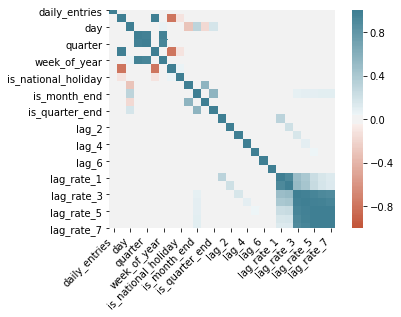

In [192]:

corr = df_model.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



In [193]:
df_model.month.head()

datetime
2010-04-17    4
2010-04-18    4
2010-04-19    4
2010-04-20    4
2010-04-21    4
Name: month, dtype: int64

In [196]:
df_model.loc[df_model.daily_entries> 2000000, "daily_entries"] = df_model.loc['2016-02-01':'2016-02-28'].daily_entries.mean()

In [197]:
df_model.loc['2016-01-01':'2016-01-31'].daily_entries.mean()

26107.942396313367

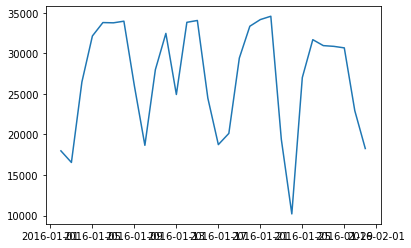

In [201]:
plt.plot(df_model.loc['2016-01-02':'2016-01-31'].daily_entries)
plt.show()

**Tratamento de outliers**

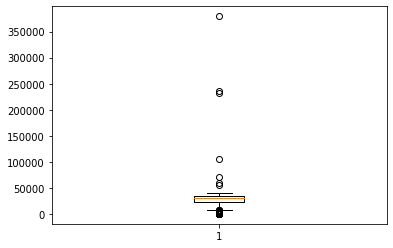

In [202]:
plt.boxplot(df_model.daily_entries)
plt.show()

In [207]:
df_model.daily_entries.median()

30038.0

In [208]:
df_model.loc[df_model.daily_entries> 50000, "daily_entries"] = df_model.daily_entries.median()


In [211]:
df_model.daily_entries.mean()

28502.46514391339

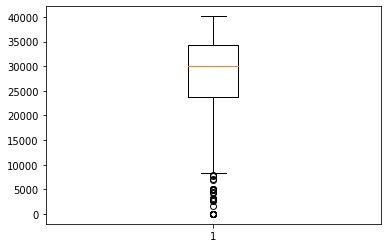

In [210]:
plt.boxplot(df_model.daily_entries)
plt.show()

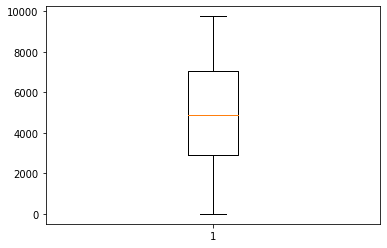

In [219]:
plt.boxplot(df_model[df_model.daily_entries<10000].daily_entries)
plt.show()

###  Baseline Model

In [220]:
#train=1 , test=0,  valid=2
df_model['istrain'] = 1
df_model.loc[df_model.index.year == 2015,'istrain'] = 0
df_model.loc[df_model.index.year == 2016,'istrain'] = -1
df_model.loc[df_model.index.year == 2017,'istrain'] = 2


In [230]:
#from sktime.datasets import load_airline
#from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import smape_loss
#from sktime.forecasting.naive import NaiveForecaster


X_train = df_model[df_model.istrain == 1].drop([ 'daily_entries','date', 'istrain'], axis = 1)
y_train = df_model[df_model.istrain == 1].daily_entries

X_test = df_model[df_model.istrain == 0].drop([ 'daily_entries', 'date','istrain'], axis = 1)
y_test = df_model[df_model.istrain == 0].daily_entries

X_valid = df_model[df_model.istrain == 2].drop([ 'daily_entries', 'date','istrain'], axis = 1)
y_valid = df_model[df_model.istrain == 2].daily_entries


In [231]:
random = 42

In [232]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((1708, 26), (1708,), (365, 26), (365,), (266, 26), (266,))

In [233]:
%%time 

rfr = RandomForestRegressor(n_estimators= 30, max_depth = 15,random_state= random)
rfr.fit(X_train, y_train)


Wall time: 331 ms


RandomForestRegressor(max_depth=15, n_estimators=30, random_state=42)

In [234]:
y_pred_valid = rfr.predict(X_valid)
y_pred_test = rfr.predict(X_test)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


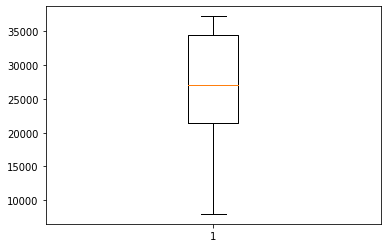

In [236]:
y_test[y_test>20000000] = y_test.mean()
plt.boxplot(y_test.values)
plt.show()

In [237]:

print('Explained Variance Score', explained_variance_score(y_test, y_pred_test)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_test, y_pred_test)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mse(y_test, y_pred_test)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_test, y_pred_test))
# mediana dos (real - predito)
print('Mean Squared Log Error:', msle(y_test, y_pred_test))
print('Root Mean Squared Log Error:', np.sqrt(msle(y_test, y_pred_test)))

#print('R² score:', r2_score(y_test, y_pred_test))

Explained Variance Score 0.9270863506042553
Max Error: 6995.992083333331
Mean Absolute Error: 1379.7007730599873
Root Mean Squared Error: 2235.5366380117403
Median Squared Error: 368.66507936507696
Mean Squared Log Error: 0.009422329657075684
Root Mean Squared Log Error: 0.0970686852546983


In [80]:
X_train.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_rate_1', 'lag_rate_2', 'lag_rate_3', 'lag_rate_4', 'lag_rate_5',
       'lag_rate_6', 'lag_rate_7', 'dayofweek', 'day', 'month', 'quarter',
       'day_of_week', 'week_of_year', 'is_business_day', 'is_national_holiday',
       'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end'],
      dtype='object')

In [87]:
pd.DataFrame({'Features': X_train.columns, 'f_importances':rfr.feature_importances_}).sort_values(by = 'f_importances', ascending = False).head(10)

,Features,f_importances
11,lag_rate_5,0.188313
5,lag_6,0.129558
7,lag_rate_1,0.117604
4,lag_5,0.098721
2,lag_3,0.064125
12,lag_rate_6,0.057424
10,lag_rate_4,0.051643
9,lag_rate_3,0.050962
13,lag_rate_7,0.043746
8,lag_rate_2,0.039349


In [419]:
df_pred = pd.DataFrame()
#df_pred['datetime'] =  y_test.index
df_pred['month'] =  y_test.index.month
df_pred['day'] =  y_test.index.day
df_pred['y_test'] = y_test.values
df_pred['y_pred_test'] = y_pred_test

In [358]:
df_pred['y_train_2014'] = y_train[y_train.index.year == 2014]

In [332]:
y_train[(y_train.index.year == 2015)
       &(y_train.index.month == 12) ].values

array([33071., 34980., 35374., 36146., 27133., 21379., 29744., 35276.,
       36331., 35604., 36235., 29273., 21709., 29473., 34514., 35707.,
       35477., 35360., 27137., 21164., 28279., 32575., 32289., 26339.,
       16537., 16541., 17342., 23403., 27368., 28793., 28389.])

In [364]:
df

,month,day,y_test,y_pred_test,y_train_2014
335,12,1,35854.0,35437.377778,NaN
336,12,2,36628.0,36084.844444,NaN
337,12,3,27249.0,27406.196878,NaN
338,12,4,22195.0,22293.592727,NaN
339,12,5,29877.0,29613.785113,NaN
340,12,6,35477.0,34684.568043,NaN
341,12,7,36580.0,36053.480233,NaN
342,12,8,36960.0,36648.077756,NaN
343,12,9,37007.0,36936.155450,NaN
344,12,10,28700.0,28544.478950,NaN


In [99]:
y_pred_test = pd.Series(y_pred_test, index = y_test.index)

In [130]:
df_model

,date,daily_entries,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_rate_1,...,quarter,day_of_week,week_of_year,is_business_day,is_national_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,istrain
datetime,,,,,,,,,,,,,,,,,,,,,
2010-04-17,2010-04-17,0.0,20546.0,29630.0,33551.0,34595.0,34542.0,34171.0,8238.0,0.000000,...,2,5,15,0,0,0,0,0,0,1
2010-04-18,2010-04-18,20546.0,29630.0,33551.0,34595.0,34542.0,34171.0,8238.0,232395.0,1.442130,...,2,6,15,0,0,0,0,0,0,1
2010-04-19,2010-04-19,29630.0,33551.0,34595.0,34542.0,34171.0,8238.0,232395.0,21222.0,1.132332,...,2,0,16,1,0,0,0,0,0,1
2010-04-20,2010-04-20,33551.0,34595.0,34542.0,34171.0,8238.0,232395.0,21222.0,29259.0,1.031117,...,2,1,16,1,0,0,0,0,0,1
2010-04-21,2010-04-21,34595.0,34542.0,34171.0,8238.0,232395.0,21222.0,29259.0,33990.0,0.998468,...,2,2,16,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-19,2017-09-19,33264.0,33527.0,30495.0,29895.0,7052.0,0.0,0.0,0.0,1.007906,...,3,1,38,1,0,0,0,0,0,2
2017-09-20,2017-09-20,33527.0,30495.0,29895.0,7052.0,0.0,0.0,0.0,0.0,0.909565,...,3,2,38,1,0,0,0,0,0,2
2017-09-21,2017-09-21,30495.0,29895.0,7052.0,0.0,0.0,0.0,0.0,0.0,0.980325,...,3,3,38,1,0,0,0,0,0,2


### Apresentação do resultado

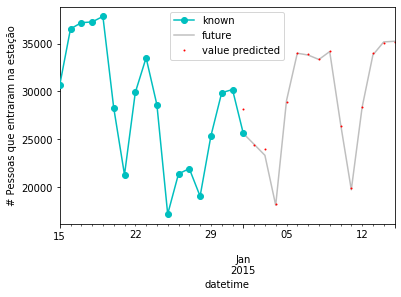

In [155]:
known = df_model.loc['2014-12-15':'2015-01-01'].daily_entries
unknown = df_model.loc['2015-01-01':'2015-01-15'].daily_entries
predicted = y_pred_test.loc['2015-01-01':'2015-01-15']

fig, ax = plt.subplots();
known.plot(ax=ax, c='c', marker='o', zorder=3);
unknown.plot(ax=ax, c='grey', alpha=0.5);
predicted.plot(ax=ax, c='r', marker='o', markersize=1,
                linestyle='');

ax.legend(['known', 'future', 'value predicted']);
ax.set_ylabel('# Pessoas que entraram na estação');

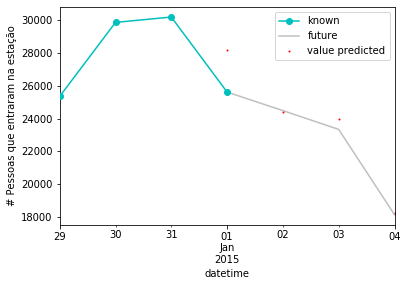

In [159]:
known = df_model.loc['2014-12-29':'2015-01-01'].daily_entries
unknown = df_model.loc['2015-01-01':'2015-01-04'].daily_entries
predicted = y_pred_test.loc['2015-01-01':'2015-01-04']

fig, ax = plt.subplots();
known.plot(ax=ax, c='c', marker='o', zorder=3);
unknown.plot(ax=ax, c='grey', alpha=0.5);
predicted.plot(ax=ax, c='r', marker='o', markersize=1,
                linestyle='');

ax.legend(['known', 'future', 'value predicted']);
ax.set_ylabel('# Pessoas que entraram na estação');

### Model Selection

* A ser desenvolvido estudo com modelos regressores, performance e tempo estimado de treinamento para escalonabilidade

### Hyperparameter Tuning
* A partir do modelo escolhido, realizar o tuning para aprimorar resultados

### Validation